<left><img width=25% src="../source/logo.png"></left>

### Applied Machine Learning

## Mehmet Can Yavuz, PhD

Adapted from Volodymyr Kuleshov, Cornell Tech

# Lecture 11: Dimensionality Reduction with MDS and TSNE

# Announcements

+ Homework 3 will be released today and due Oct 23

# Last class: PCA

* __Type__: Unsupervised learning (dimensionality reduction)
* __Model family__: Linear projection ($f_\theta(x)=W^\top x$)
* __Objective function__: Reconstruction error or variance maximization
* __Optimizer__: Matrix eigendecomposition

# PCA losses: max variance = min reconstruction

<center><img width=50% src="img/pca_two_views.png"></center>

$$\arg\max_\theta \sum_{i=1}^n \left[ \| f_\theta(x^{(i)}) - \sum_{j=1}^n[f_\theta(x^{(j)})] \|^2 \right] = \arg\min_\theta \sum_{i=1}^n \| x^{(i)} - f_\theta^{-1}(f_\theta(x^{(i)})) \|_2^2$$

# When PCA fails

PCA is intuitive and easy to implement, but fails on non-linear structures

Let's consider this 2D S-curve. **What will the PCA look like?**

In [1]:
import numpy as np; np.set_printoptions(precision=2)
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = [12, 4]
from sklearn.datasets import make_s_curve

def make_s_curve_2d(n_samples=100, noise=0.0):
    np.random.seed(0)
    X, y = make_s_curve(n_samples=n_samples, noise=noise)
    X = X[:, [0, 2]]
    X = (X-X.mean(axis=0)) / X.std(axis=0)
    return X, y

def fig_ax_with_padding():
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    ax = axs[1]; axs[0].axis('off'); axs[2].axis('off')
    ax.set_xlim(-2, 2); ax.set_ylim(-2, 2)
    return fig, axs[1]


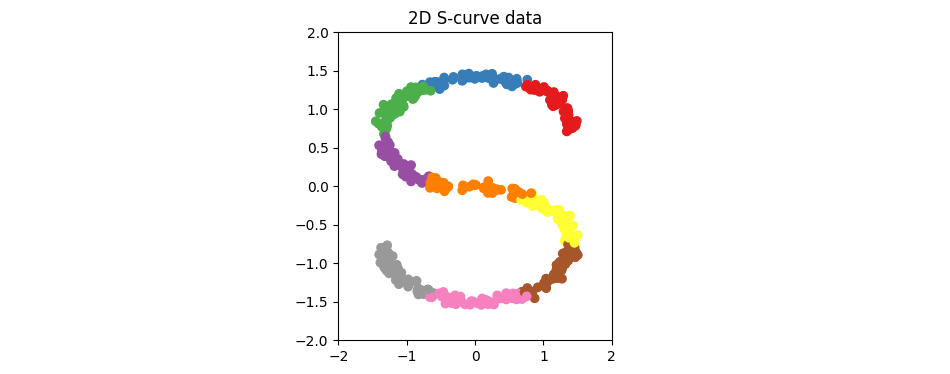

In [2]:
X, y = make_s_curve_2d(n_samples=500, noise=0.05)
fig, ax = fig_ax_with_padding()
ax.set_title('2D S-curve data')
ax.scatter(X[:,0], X[:,1], c=y, cmap='Set1');

Running our PCA implementation on it gives:

In [3]:
def plot_pca_1d(X, Z, W):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].scatter(X[:,0], X[:,1], c=y, cmap='Set1')
    axs[0].set_title('2D S-curve data')
    axs[0].set_xlabel("$x_0$")
    axs[0].set_ylabel("$x_1$")

    Z, W = pca_project(X, p=1)
    axs[1].scatter(Z, np.zeros_like(Z), c=y, cmap='Set1')
    axs[1].set_title('1D PCA projection')
    axs[1].set_xlabel('$z_0$')
    axs[1].set_yticks([])

    W_ortho = np.array([W[1,0], -W[0,0]])
    axs[0].arrow(0, 0, W_ortho[0], W_ortho[1], head_width=0.2, head_length=0.2, fc='k', ec='k', lw=2)
    axs[0].plot([-5.*W[0,0], 5.*W[0,0]], [-5.*W[1,0], 5.*W[1,0]], '--', lw=2, color='k')
    axs[0].set_xlim((-2., 2.)); axs[0].set_ylim((-2., 2.))
    
    axs[0].set_aspect('equal')

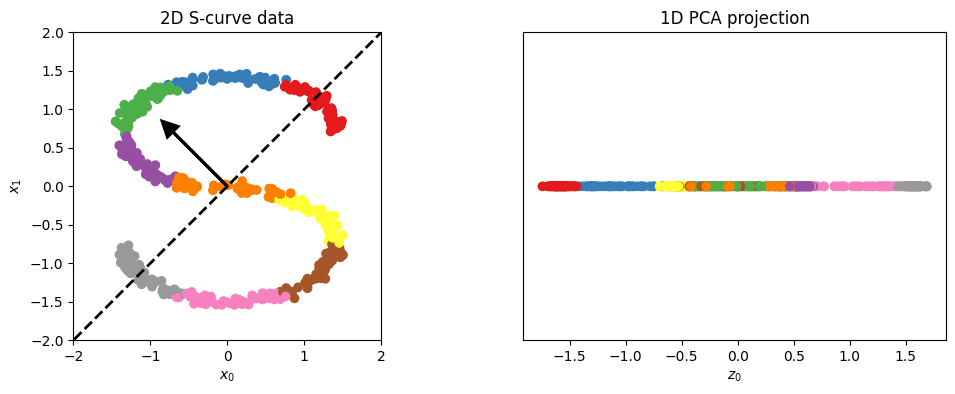

In [4]:
def pca_project(X, p=2):
    np.random.seed(0)
    Sigma = X.T.dot(X) / X.shape[0] # form covariance matrix
    L, Q = np.linalg.eig(Sigma) # perform eigendecomposition
    W = Q[:,:p] # get top p eigenvectors
    Z = X.dot(W) # project on these eigenvectors
    return np.real(Z), W # return projected points and the projection matrix

Z, W = pca_project(X, p=2)
plot_pca_1d(X, Z, W)

In [5]:
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

def visualize_pca_mds_tsne(X, y=None, p=2, tsne_perplexity=30, extra_plot_kwargs=None, ax_cb=None, legend=None):
    assert p in [1, 2]
    nrow = 1
    ncol = 3 if p == 2 else 4
    fig, axs = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*4))

    plot_kwargs = {}
    if y is not None:
        plot_kwargs['c'] = y
        plot_kwargs['cmap'] = 'Set1'
    if extra_plot_kwargs is not None:
        plot_kwargs.update(extra_plot_kwargs)

    if p == 1:
        axs[0].scatter(X[:,0], X[:,1], **plot_kwargs)
        axs[0].set_title('2D S-curve data')
        axs[0].set_xlabel("$x_0$")
        axs[0].set_ylabel("$x_1$")
        axs = axs[1:]

    X_centered = X-X.mean()
    Z, W = pca_project(X_centered, p=p)
    zeros = np.zeros_like(Z)
    p1 = axs[0].scatter(Z[:,0], Z[:,1] if p == 2 else zeros, **plot_kwargs)
    if y is not None and legend:
        handles, labels = p1.legend_elements()
        axs[0].legend(handles=handles, labels=legend)
    axs[0].set_title('PCA')
    axs[0].set_xlabel('$z_0$')
    axs[0].set_yticks([])
    if p == 2:
        axs[0].set_ylabel('$z_1$')
    if ax_cb is not None:
        ax_cb(Z, axs[0])

    
    np.random.seed(0)
    Z = MDS(n_components=p, normalized_stress='auto').fit_transform(X)
    axs[1].scatter(Z[:,0], Z[:,1] if p == 2 else zeros, **plot_kwargs)
    axs[1].set_title('MDS')
    axs[1].set_xlabel('$z_0$')
    axs[1].set_yticks([])
    if p == 2:
        axs[1].set_ylabel('$z_1$')
    if ax_cb is not None:
        ax_cb(Z, axs[1])

    np.random.seed(0)
    Z = TSNE(n_components=p, perplexity=tsne_perplexity).fit_transform(X)
    axs[2].scatter(Z[:,0], Z[:,1] if p == 2 else zeros, **plot_kwargs)
    axs[2].set_title('TSNE')
    axs[2].set_xlabel('$z_0$')
    axs[2].set_yticks([])
    if p == 2:
        axs[2].set_ylabel('$z_1$')
    if ax_cb is not None:
        ax_cb(Z, axs[2])

    return fig, axs

**So what happened?** PCA's linear projection fails on the non-linear structure

**This class:** Two non-linear visualization and embedding methods:
1. Multidimensional scaling (MDS)
2. $t$-distributed stochastic neighbor embedding (t-SNE)

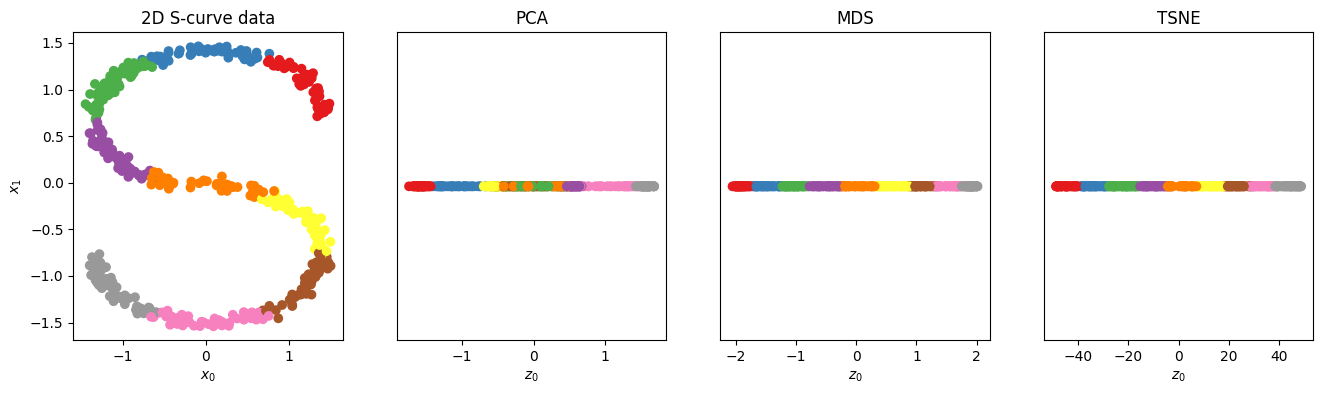

In [6]:
visualize_pca_mds_tsne(X, y, p=1);

# Part 2: t-distributed stochastic neighbor embedding (TSNE)

<center>
47.8k citations (Oct 9, 2024) <br/>
<img width='70%' src="../source/img/tsne-paper.png"/>
</center>

# Difficulties of reproducing pairwise distances

Reproducing all of the pairwise distances in a lower-dimensional space is hard,
even when we have full control over the embedding locations.

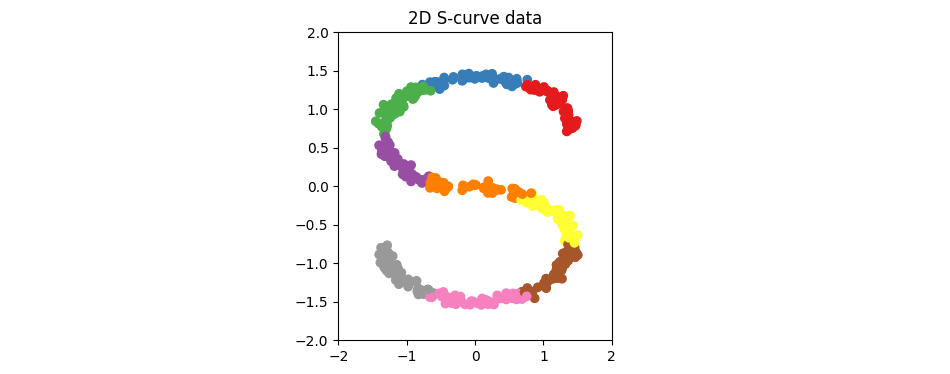

In [7]:
fig # display the MDS distances from before

# How to improve poor pairwise distance reconstructions?

1. If we just care about reproducing the distances ad not visualization, we could make the dimension of the embedding space larger
2. If we want to stay in a low-dimensional space, we can change the notion of distance (this is what TSNE does)

# Probabilistic (stochastic) pairwise distances

Given a point $x^{(i)}$, measure the "distance" to another point by the probability the distance to that point was sampled from a Gaussian, and normalize it.

Formally for $j\neq i$, this is $p_{j|i}\propto \exp\{-\|x^{(i)}-x^{(j)}\|^2/2\sigma_i^2\}$
normalized so that $\sum_j p_{j|i} = 1$.
Then, the probabilities are symmetrized as $p_{ij} \propto p_{j|i} + p_{i|j}$.

<center>
<img width='40%' src='../source/img/tsne.jpeg'/> <br/>
<small><span style='color: grey'>Image source: https://spotintelligence.com/2023/12/22/practical-guide-t-sne/</span></small>
</center>

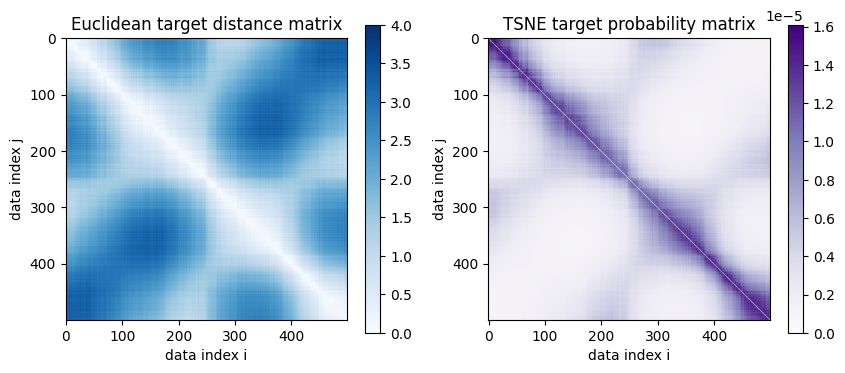

In [13]:
from sklearn.metrics.pairwise import euclidean_distances

I = np.argsort(y); y = y[I]; X = X[I]; Z = Z[I];

D_original = euclidean_distances(X)

def gaussian_distances(X, bandwidth):
    return np.exp(-euclidean_distances(X) / (2.*bandwidth))

def get_tsne_target_probability(X, bandwidth=0.6):
    D = gaussian_distances(X, bandwidth=bandwidth) # in the full TSNE, the bandwidth searched over for each i.
    p_j_given_i = D / (D.sum(axis=1) - 1.) # normalize the distances so \sum_j p_{j|i}=1 for every i.
    np.fill_diagonal(p_j_given_i, 0.) # p_{i|i} = 0 for every i.
    p_ij = (p_j_given_i + p_j_given_i.T) / (2.*X.shape[0]) # symmetrize and normalize so \sum_{i,j} p_{i,j} = 1.
    return p_ij

p_ij = get_tsne_target_probability(X)
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
img = axs[0].imshow(D_original, cmap='Blues', vmin=0., vmax=4.); fig.colorbar(img)
img = axs[1].imshow(p_ij, cmap='Purples'); fig.colorbar(img)
axs[0].set_title('Euclidean target distance matrix'); axs[1].set_title('TSNE target probability matrix')
for ax in axs: ax.set_xlabel('data index i'); ax.set_ylabel('data index j')

We can also see that the new pairwise similarity matrix is a valid probability distribution and has entries that sum to 1:

In [14]:
print(f'sum_ij p_ij: {p_ij.sum():.2f}')

sum_ij p_ij: 1.00


# The TSNE loss: the Kullback-Leibler

Let's call $P_X$ the similarity matrix of the true data and $Q_\theta$ the similarity matrix of the embeddings.
Since these are valid probability distributions, we can define the loss to be the distance between them.
TSNE does this with the Kullback-Leibler divergence:

$$J_{\rm TSNE}={\rm KL}(P_X||Q_\theta):=\sum_{i\neq j} p_{ij}\log\frac{p_{ij}}{q_{ij}}$$

<center>
<img width='50%' src='img/kl.jpg'/> <br/>
<small><span style='color: grey'>Image source: https://blog.evjang.com/2016/08/variational-bayes.html</span></small>
</center>

# TSNE's perplexity parameter

In creating $p_{j|i}\propto \exp\{-\|x^{(i)}-x^{(j)}\|^2/2\sigma_i^2\}$, there is the choice of what bandwidth $\sigma_i$ to use.

TSNE advocates to adaptively set the bandwidth different for every $i$ so every $p_{j|i}$ has the same **entropy** and **perplexity**.

The **entropy** of a categorical distribution is defined by $H(p)=-\sum_j p_j \log p_j$, and the **perplexity** is defined by ${\rm Perp}(p) = 2^{H(p)}$

We can think of the perplexity parameter as controlling how spread out the mass of the reference distribution is &mdash; how many neighbors are used. One way to see this is just to ablate across constant bandwidths. We'll ablate it more later.

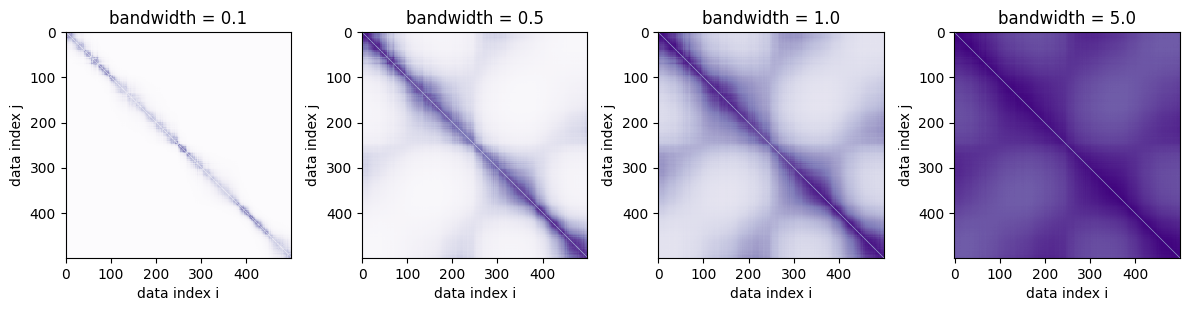

In [16]:
bandwidths = [0.1, 0.5, 1.0, 5.0]

fig, axs = plt.subplots(1, len(bandwidths), figsize=(12,4))
for ax, bandwidth in zip(axs, bandwidths):
    ax.set_xlabel('data index i'); ax.set_ylabel('data index j')
    p = get_tsne_target_probability(X, bandwidth=bandwidth)
    ax.imshow(p, cmap='Purples')
    ax.set_title(f'bandwidth = {bandwidth:.1f}')
fig.tight_layout()

# Constructing $Q_\theta$ with a student's t

TSNE uses a Gaussian to construct the reference similarity matrix $P_X$,
but advocates for another choices for the embedded similarity matrix $Q_\theta$.

They argue for a student's $t$ distribution to help ignore dissimilar points.

# Optimizing TSNE

The formulation for TSNE is thus
$$\arg\min_\theta \{J_{\rm TSNE}(\theta) := {\rm KL}(P_X, Q_\theta) \}$$
where $P_X$ is the data similarity matrix and $Q_\theta$ is the similarity matrix
induced by the embeddings.

# Optimizing TSNE

Like in metric MDS, the solution is not known in closed form. It is often approximated with gradient-based optimization, which in the simplest form is:

1. Initialize the embeddings $\theta=\left\{z_i\right\}$.
2. Repeat until converged
    + $\theta\gets \theta-\alpha \nabla_\theta J_{\rm TSNE}(\theta)$

# TSNE

* __Type__: Unsupervised learning (dimensionality reduction)
* __Model family__: Embeddings ($f_\theta(x^{(i)})=z^{(i)}$)
* __Objective function__: KL between probabilistic similarities, $J_{\rm TSNE}={\rm KL}(P_X || Q_\theta)$
* __Optimizer__: Gradient descent

# Part 3: Visualizing high-dimensional data

We now apply PCA, MDS, and TSNE to some high-dimensional data.

# Newsgroups

We'll start with the newsgroups data from the Naïve Bayes lecture.

In [17]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
count_vect = CountVectorizer(binary=True, max_features=100)
X = count_vect.fit_transform(twenty_train.data).toarray().astype(np.float32)
y = twenty_train.target
np.random.seed(0)
idx = np.random.choice(X.shape[0], size=500, replace=False)
X, y = X[idx], y[idx]
print('a single example: ', X[0])

a single example:  [0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 0.]


The visualizations for the newsgroup data is:

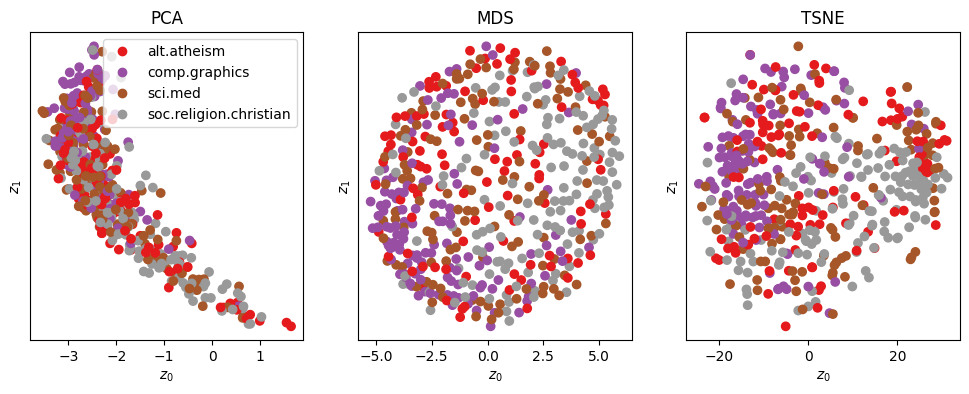

In [18]:
visualize_pca_mds_tsne(X, y, p=2, legend=twenty_train['target_names']);

# Visualizing image data: MNIST

This classic dataset consists of grayscale images representing handwritten digits

image pixel values:  [0.   0.   0.   0.   0.   0.35 0.58 0.58 0.98 0.9  0.23]


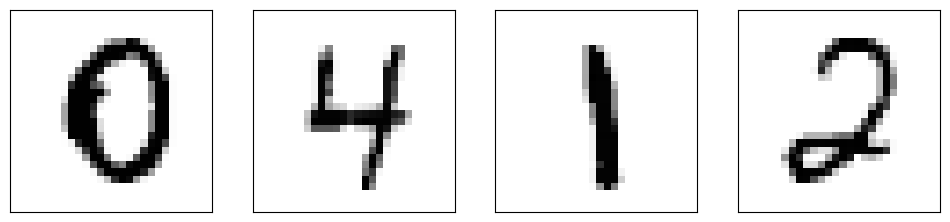

In [19]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False, parser='auto')
np.random.seed(0)
idx = np.random.choice(X.shape[0], size=1000, replace=False)
X, y = X[idx], y[idx]
X = X.astype(np.float64) / 255.
y = y.astype(int)
print('image pixel values: ', X[0][120:131])
fig, axs = plt.subplots(ncols=4)
for i, ax in enumerate(axs):
    ax.imshow(X[i].reshape((28, 28)), cmap='Greys')
    ax.set_xticks([]); ax.set_yticks([])

TSNE clearly visualizes the clusters in the MNIST data better than PCA and MDS. This was a key component of their original paper.

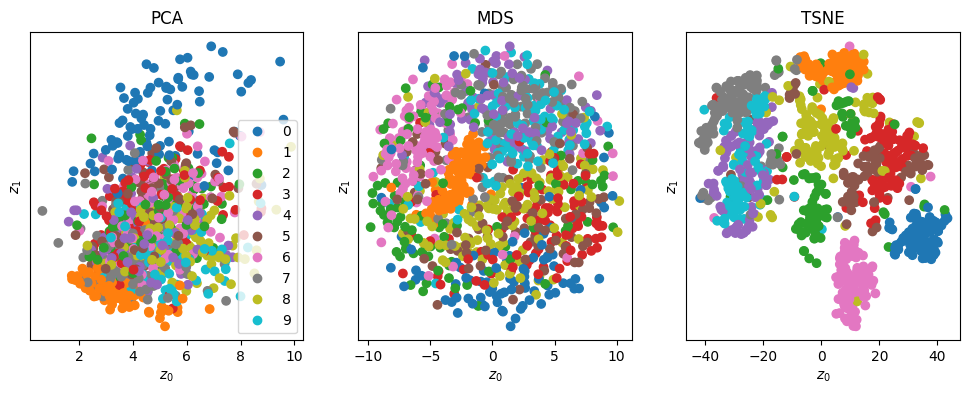

In [20]:
legend = [str(i) for i in range(10)]
visualize_pca_mds_tsne(X, y, p=2, extra_plot_kwargs={'cmap': 'tab10'}, legend=legend);

We can also use the MNIST data to ablate TSNE's perplexity parameter, controlling how many neighbors are taken into consideration:

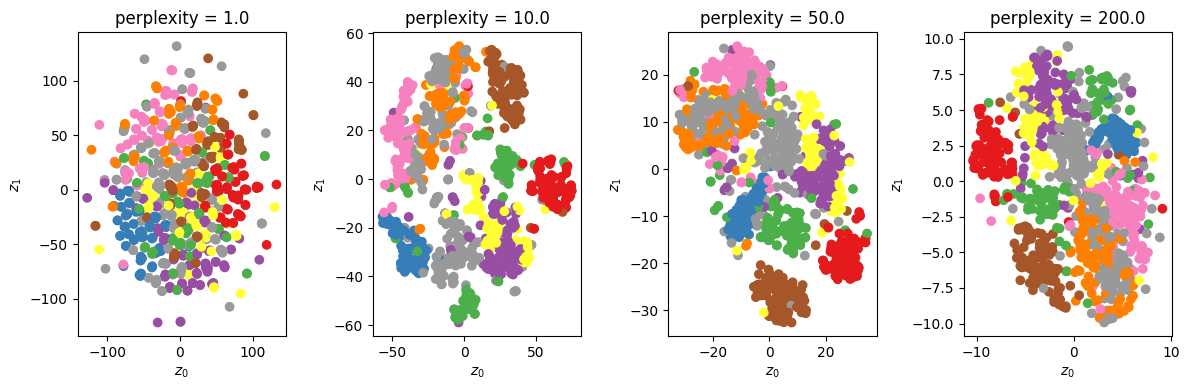

In [21]:
perplexities = [1.0, 10., 50., 200.]

fig, axs = plt.subplots(1, len(bandwidths), figsize=(12,4))
for ax, perplexity in zip(axs, perplexities):
    ax.set_xlabel('$z_0$'); ax.set_ylabel('$z_1$')
    Z = TSNE(n_components=2, perplexity=perplexity).fit_transform(X)
    ax.scatter(Z[:,0], Z[:,1], c=y, cmap='Set1')
    ax.set_title(f'perplexity = {perplexity:.1f}')
fig.tight_layout()

# Voting data

We'll next look at some congressional voting data from congress members in 1984.

```
house.votes.84: United States Congressional Voting Records 1984

This data set includes votes for each of the U.S. House of Representatives Congressmen on the 16 key votes identified by the CQA. The CQA lists nine different types of votes: voted for, paired for, and announced for (these three simplified to yea), voted against, paired against, and announced against (these three simplified to nay), voted present, voted present to avoid conflict of interest, and did not vote or otherwise make a position known (these three simplified to an unknown disposition).
```

In [22]:
import requests
import pandas as pd; pd.options.display.float_format = "{:,.2f}".format

def get_voting_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data"
    response = requests.get(url)
    fname = '/tmp/house-votes-84.data'
    with open(fname, 'wb') as f:
        f.write(response.content)
    FEATURES  = [
        "class_name",
        "handicapped_infants",
        "water_project_cost_sharing",
        "adoption_of_the_budget_resolution",
        "physician_fee_freeze",
        "el_salvador_aid",
        "religious_groups_in_schools",
        "anti_satellite_test_ban",
        "aid_to_nicaraguan_contras",
        "mx_missile",
        "immigration",
        "synfuels_corporation_cutback",
        "education_spending",
        "superfund_right_to_sue",
        "crime",
        "duty_free_exports",
        "export_administration_act_south_africa"
    ]
    df = pd.read_csv(fname, sep=',', header=None, names=FEATURES)
    numeric_df = df.replace({'n': -1, 'y': 1, '?':0, 'republican': 1, 'democrat': 2})
    X = numeric_df.drop(columns=['class_name']).to_numpy()
    y = numeric_df['class_name'].to_numpy()
    return df, X, y

Here's what the data looks like.

In [23]:
df, X, y = get_voting_data()
print(f'label={y[0]}, features={X[0]}')
df.head()

label=1, features=[-1  1 -1  1  1  1 -1 -1 -1  1  0  1  1  1 -1  1]


,class_name,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


And embedding the voting records gives:

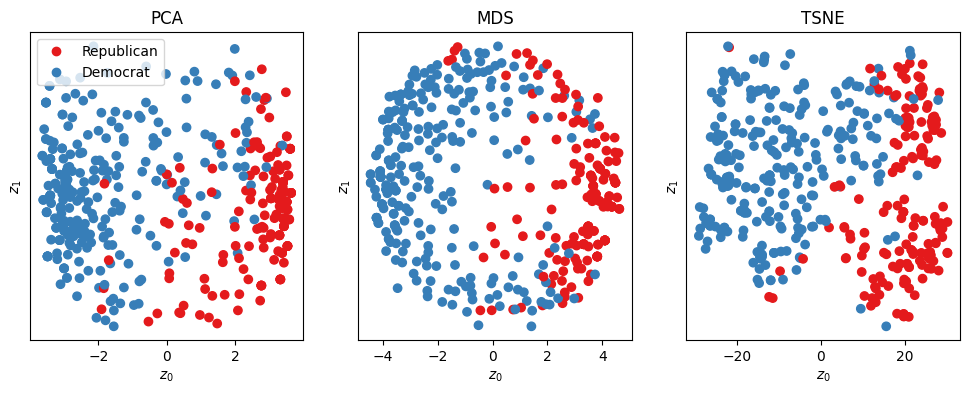

In [24]:
visualize_pca_mds_tsne(X, y, p=2, extra_plot_kwargs={'vmax': 8}, legend=['Republican', 'Democrat']);

# Visualizing word embeddings

We'll last look at GloVe word embeddings (we could also use word2vec or fasttext embeddings). These are already semantically-rich vectors of words. Let's look at a few.

In [ ]:
from embeddings import GloveEmbedding
glove = GloveEmbedding('common_crawl_840', d_emb=300, show_progress=True)

def ax_cb(Z, ax):
    for word, Zi in zip(words, Z):
        ax.text(Zi[0], Zi[1], word, fontsize=8, va='bottom', ha='left')

/opt/anaconda3/envs/applied-machine-learning/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nlp.stanford.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/opt/anaconda3/envs/applied-machine-learning/lib/python3.8/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'downloads.cs.stanford.edu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [ ]:
words = ["joyful", "happy", "sad", "angry", "fearful", "loving", "hateful", "surprised",
         "disgusted", "excited", "calm", "anxious", "frustrated", "hopeful",
         "despairing", "trusting", "distrustful", "envious", "compassionate", "grieving", "curious"]
embeddings = np.array([glove.emb(word) for word in words])
for i in range(5):
    print(f'word: {words[i]}\tembedding[:10]: {embeddings[i,:10]}')

It's still hard to visualize how they relate to each other in this high-dimensional space, so let's embed them into 2 dimensions:

In [ ]:
fig, axs = visualize_pca_mds_tsne(embeddings, p=2, tsne_perplexity=10, ax_cb=ax_cb)

Lastly let's look at another set of words:

In [ ]:
words = ["apple", "cat", "dog", "banana", "chair", "pencil", "shoe", "lamp", "bicycle",
         "book", "pillow", "guitar", "mug", "tree", "clock",
         "blanket", "spoon", "laptop", "hat", "door", "bottle"]
embeddings = np.array([glove.emb(word) for word in words])
fig, axs = visualize_pca_mds_tsne(embeddings, p=2, tsne_perplexity=10, ax_cb=ax_cb)